In [1]:
import yfinance as yf
btc = yf.Ticker("BTC-USD")
data = btc.history(period="5y")  # Get last 5 years of data
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-17 00:00:00+00:00,5002.578125,5371.348633,4981.909180,5225.629395,38622642935,0.0,0.0
2020-03-18 00:00:00+00:00,5227.113770,5331.833984,5069.335938,5238.438477,37878801016,0.0,0.0
2020-03-19 00:00:00+00:00,5245.416504,6329.735840,5236.968750,6191.192871,51000731797,0.0,0.0
2020-03-20 00:00:00+00:00,6191.653809,6844.261719,5865.781738,6198.778320,54442976103,0.0,0.0
2020-03-21 00:00:00+00:00,6206.521484,6378.135254,5932.823242,6185.066406,42494390880,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 00:00:00+00:00,83724.921875,84301.695312,79931.851562,81066.703125,31412940153,0.0,0.0
2025-03-14 00:00:00+00:00,81066.992188,85263.289062,80797.562500,83969.101562,29588112414,0.0,0.0
2025-03-15 00:00:00+00:00,83968.406250,84672.671875,83639.593750,84343.109375,13650491277,0.0,0.0


<Axes: xlabel='Date'>

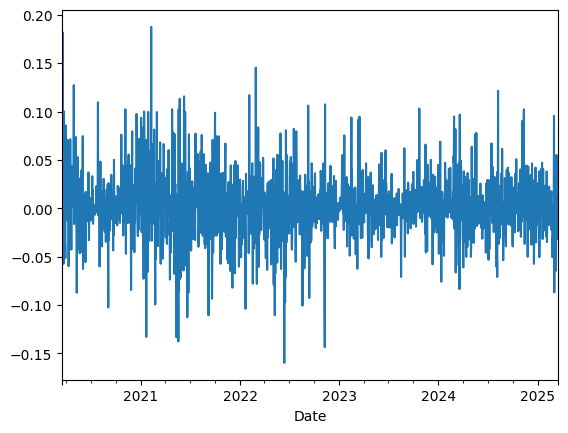

In [2]:
data['Daily Return'] = data['Close'].pct_change()
data['Daily Return'].plot()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

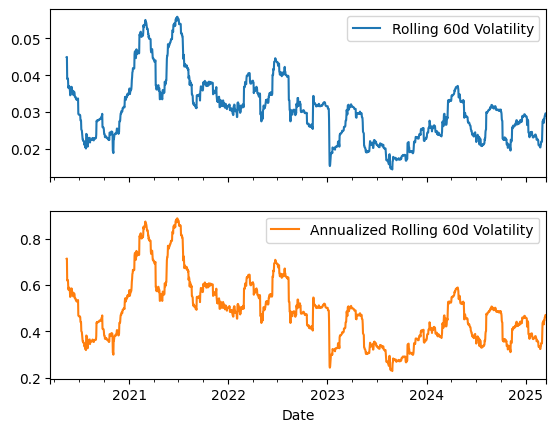

In [3]:
# Calculate rolling 60-day standard deviation of daily returns
data['Rolling 60d Volatility'] = data['Daily Return'].rolling(window=60).std()

# Annualize the rolling volatility (assuming 252 trading days in a year)
data['Annualized Rolling 60d Volatility'] = data['Rolling 60d Volatility'] * (252 ** 0.5)

data[['Rolling 60d Volatility', 'Annualized Rolling 60d Volatility']].plot(subplots=True)

In [4]:
msft = yf.Ticker("MSFT")

expirations = msft.options
print(f"{len(expirations)} available expiration dates:", expirations)

# Choose an expiration date (for example, the first available one)
expiration_date = expirations[0]

# Fetch the option chain for the chosen expiration date
option_chain = msft.option_chain(expiration_date)

# Display the calls and puts
calls = option_chain.calls
puts = option_chain.puts

print("Calls:")
print(calls.head())

print("\nPuts:")
print(puts.head())

21 available expiration dates: ('2025-03-21', '2025-03-28', '2025-04-04', '2025-04-11', '2025-04-17', '2025-04-25', '2025-05-02', '2025-05-16', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-06-17', '2027-12-17')
Calls:
        contractSymbol             lastTradeDate  strike  lastPrice  bid  ask  \
0  MSFT250321C00200000 2025-03-13 19:45:31+00:00   200.0     178.30  0.0  0.0   
1  MSFT250321C00210000 2025-03-11 19:20:09+00:00   210.0     174.07  0.0  0.0   
2  MSFT250321C00220000 2025-03-05 15:11:09+00:00   220.0     172.41  0.0  0.0   
3  MSFT250321C00230000 2025-02-19 17:17:44+00:00   230.0     180.74  0.0  0.0   
4  MSFT250321C00240000 2025-02-25 15:23:08+00:00   240.0     160.00  0.0  0.0   

   change  percentChange  volume  openInterest  impliedVolatility  inTheMoney  \
0     0.0            0.0     6.0           438            0.00001        True   
1     0.0         

In [10]:
import QuantLib as ql

spot = 100
strike = 100
rate = 0.035
div_yield = 0.05
volatility = 0.1
maturity = ql.Date(30,6,2025)

calculation_date = ql.Date().todaysDate()  # Arbitrary calculation date
print(calculation_date)
ql.Settings.instance().evaluationDate = calculation_date

payoff = ql.PlainVanillaPayoff(ql.Option.Call, strike)
exercise = ql.AmericanExercise(
    calculation_date, maturity
)

option = ql.VanillaOption(payoff, exercise)

today = ql.Date().todaysDate()
riskFreeTS = ql.YieldTermStructureHandle(ql.FlatForward(today, rate, ql.Actual365Fixed()))
dividendTS = ql.YieldTermStructureHandle(ql.FlatForward(today, div_yield, ql.Actual365Fixed()))
volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), volatility, ql.Actual365Fixed()))
initialValue = ql.QuoteHandle(ql.SimpleQuote(spot))
process = ql.BlackScholesMertonProcess(initialValue, dividendTS, riskFreeTS, volatility)

tGrid, xGrid = 2000, 200
engine = ql.FdBlackScholesVanillaEngine(process, tGrid, xGrid)
option.setPricingEngine(engine)

option.NPV(), option.delta()

March 18th, 2025


(1.936881186984444, 0.4848689043481677)

In [11]:
dividend_dates = [ql.Date(1, ql.June, 2025)]
dividends = [5.0]


In [ ]:

calculation_date = ql.Date().todaysDate()  # Arbitrary calculation date
ql.Settings.instance().evaluationDate = calculation_date
day_counter = ql.Actual365Fixed()
discount_curve = ql.FlatForward(today, 0.035, day_counter)
oneyear = ql.Date().todaysDate() + ql.Period(1, ql.Years)
discount_curve.discount(oneyear)




0.9656054162575665

In [20]:
day_counter = ql.Actual365Fixed()
calendar = ql.NullCalendar()
discount_curve = ql.FlatForward(today, rate, day_counter)
discount_dates = [today]  # Start with the reference date
discount_factors = [1.0]    
for dividend_date, dividend_amount in zip(dividend_dates, dividends):
    discount_dates.append(dividend_date)
    discount_factor_before = discount_curve.discount(dividend_date)
    #We add the dividend as a negative discount factor. Effectively lowering the discount factor at the dividend date.
    discount_factors.append(discount_factor_before - (1/dividend_amount)*discount_factor_before)
    print(discount_factor_before, discount_factors)
# Create the DiscountCurve and YieldTermStructureHandle
dividend_curve = ql.DiscountCurve(discount_dates, discount_factors, day_counter, calendar)
dividend_curve_handle = ql.YieldTermStructureHandle(dividend_curve)

0.9928340181498791 [1.0, 0.7942672145199033]


In [9]:

dividend_curve = ql.ZeroCurve(dividend_curve_dates, dividend_curve_rates, ql.Actual365Fixed())
risk_free_rate_ts = ql.FlatForward(today, rate, ql.Actual365Fixed())

# Adjust the dividend yield curve for the discrete dividends
adjusted_rates = []
for date, dividend in zip(dividend_curve_dates, dividend_curve_amount):
    if date in dividend_dates:
        discount_factor = risk_free_rate_ts.discount(date)
        dividend_yield_adjustment = dividend / (spot * discount_factor)
        adjusted_rate = div_yield + dividend_yield_adjustment
        print(dividend, discount_factor, dividend_yield_adjustment, adjusted_rate)
    else:
        adjusted_rate = div_yield
    adjusted_rates.append(adjusted_rate)
print(adjusted_rates)
adjusted_dividend_curve = ql.ZeroCurve(dividend_curve_dates, adjusted_rates, ql.Actual365Fixed())
dividend_yield_ts = ql.YieldTermStructureHandle(adjusted_dividend_curve)

NameError: name 'ql' is not defined

In [51]:
dividend_yield_ts.discount(ql.Date(30, ql.June, 2025)), dividend_yield_ts.zeroRate(ql.Date(30, ql.June, 2025), ql.Actual365Fixed(), ql.Continuous).rate()

(1.0, 0.0)

In [31]:
process = ql.BlackScholesMertonProcess(initialValue, dividend_yield_ts, riskFreeTS, volatility)

engine = ql.FdBlackScholesVanillaEngine(process, tGrid, xGrid)
option2 = ql.VanillaOption(payoff, exercise)
option2.setPricingEngine(engine)
option2.NPV(), option2.delta()

(2.6673560091708706, 0.5850199599027576)

### Stock forward value

In [52]:
import QuantLib as ql

def calculate_forward_stock_value(
    valuation_date,
    spot_price,
    dividend_dates,
    dividend_amounts,
    risk_free_curve,
    forward_date,
):
    """
    Calculates the forward value of a stock using QuantLib.

    Args:
        valuation_date (ql.Date): The valuation date.
        spot_price (float): The current spot price of the stock.
        dividend_dates (list of ql.Date): A list of dividend dates.
        dividend_amounts (list of float): A list of dividend amounts corresponding to the dividend dates.
        risk_free_curve (ql.YieldTermStructure): The risk-free yield curve.
        forward_date (ql.Date): The forward date.

    Returns:
        float: The forward value of the stock.
    """

    ql.Settings.instance().evaluationDate = valuation_date

    # Calculate the present value of dividends
    dividend_pv = 0.0
    for date, amount in zip(dividend_dates, dividend_amounts):
        dividend_pv += amount * risk_free_curve.discount(date)

    # Calculate the forward factor
    forward_factor = risk_free_curve.discount(forward_date) / risk_free_curve.discount(valuation_date)

    # Calculate the forward price
    forward_price = (spot_price - dividend_pv * risk_free_curve.discount(valuation_date)) / forward_factor

    return forward_price

# Example usage
valuation_date = ql.Date(15, 1, 2024)
spot_price = 100.0
dividend_dates = [ql.Date(15, 3, 2024), ql.Date(15, 9, 2024)]
dividend_amounts = [0.2, 0.3]
forward_date = ql.Date(15, 1, 2025)

# Create a flat yield curve for simplicity
rate = 0.05  # 5% annual rate
day_count = ql.Actual365Fixed()
calendar = ql.NullCalendar()
risk_free_curve = ql.FlatForward(valuation_date, rate, day_count)

# Calculate the forward stock value
forward_value = calculate_forward_stock_value(
    valuation_date,
    spot_price,
    dividend_dates,
    dividend_amounts,
    risk_free_curve,
    forward_date,
)

print(f"Forward stock value: {forward_value} {risk_free_curve.discount(valuation_date)}")

Forward stock value: 104.62789401666697 1.0


In [26]:
import QuantLib as ql
import math

def build_forward_dividend_curve_handle(dividend_dates, dividend_amounts, reference_date, risk_free_rate, dividend_yield):
    """
    Builds a YieldTermStructureHandle representing a forward dividend curve.

    Args:
        dividend_dates: A list of dividend dates (QuantLib Date objects).
        dividend_amounts: A list of dividend amounts (floats).
        reference_date: The reference date (QuantLib Date object).
        risk_free_rate: The risk-free rate (float).
        dividend_yield: The dividend yield (float).

    Returns:
        A YieldTermStructureHandle representing the forward dividend curve.
    """

    ql.Settings.instance().evaluationDate = reference_date
    day_counter = ql.Actual365Fixed()
    calendar = ql.NullCalendar()
    risk_free_curve = ql.FlatForward(reference_date, risk_free_rate, day_counter)

    discount_dates = [reference_date]
    discount_factors = [1.0]

    for dividend_date, dividend_amount in zip(dividend_dates, dividend_amounts):
        # Calculate the discount factor from the reference date to the dividend date using risk free rate.
        discount_factor_risk_free = risk_free_curve.discount(dividend_date)

        # Calculate the forward dividend amount, incorporating dividend yield growth.
        time_to_dividend = day_counter.yearFraction(reference_date, dividend_date)
        forward_dividend_amount = dividend_amount * math.exp(dividend_yield * time_to_dividend)

        # Build the discount curve, reflecting the forward dividend.
        adjusted_discount_factor = discount_factor_risk_free - forward_dividend_amount * discount_factor_risk_free
        print(discount_factor_risk_free, forward_dividend_amount, forward_dividend_amount * discount_factor_risk_free, adjusted_discount_factor)
        discount_dates.append(dividend_date)
        discount_factors.append(adjusted_discount_factor)

    # Add a final date to ensure the curve extends beyond the last dividend.
    if len(dividend_dates)>0:
        last_dividend_date = dividend_dates[-1]
        extra_date = ql.Date(last_dividend_date.dayOfMonth(), last_dividend_date.month(), last_dividend_date.year()+1)
        discount_dates.append(extra_date)
        discount_factors.append(risk_free_curve.discount(extra_date))

    dividend_curve = ql.DiscountCurve(discount_dates, discount_factors, day_counter, calendar)
    dividend_curve_handle = ql.YieldTermStructureHandle(dividend_curve)

    return dividend_curve_handle

# Example Usage
reference_date = ql.Date(1, 1, 2024)
dividend_dates = [ql.Date(15, 3, 2024), ql.Date(15, 6, 2024), ql.Date(15, 9, 2024)]
dividend_amounts = [1.0, 1.2, 1.1]
risk_free_rate = 0.05
dividend_yield = 0.02

dividend_curve_handle = build_forward_dividend_curve_handle(
    dividend_dates, dividend_amounts, reference_date, risk_free_rate, dividend_yield
)

# Example to demonstrate a discount factor.
test_date = ql.Date(16, 3, 2024)
print(dividend_curve_handle.discount(test_date))

test_date_before_div = ql.Date(14,3,2024);
test_date_after_div = ql.Date(16,3,2024);

print("Discount before div: ", dividend_curve_handle.discount(test_date_before_div))
print("Discount after div: ", dividend_curve_handle.discount(test_date_after_div))

0.9899142197731114 1.0040630263221775 0.9939362673047474 -0.0040220475316359305
0.9775168728661981 1.2109648604795542 1.1837385835668257 -0.20622171070062756
0.9652747860891632 1.1156611246560404 1.0769195534503546 -0.11164476736119144


RuntimeError: negative discount

In [39]:
dates = [ql.Date(15,6,2020), ql.Date(15,6,2022), ql.Date(15,6,2023)]
rates = [0.02, 0.03, 0.04]

curve = ql.ForwardCurve(dates, rates, ql.Actual360())
curve.forwardRate(ql.Date(15,7,2020), ql.Date(17,6,2021), ql.Actual360(), ql.Continuous, ql.Annual).rate(), curve.discount(ql.Date(15,6,2022)), curve.discount(ql.Date(15,6,2023))

(0.029999999999999978, 0.9409800567170211, 0.9035815717171762)

In [ ]:
import re
import sys

def reconstruct_order_book_from_stdin():
    """
    Reconstructs the order book from standard input.
    """

    order_book = {
        "BUY_PRICE": None,
        "SELL_PRICE": None,
        "LAST": None,
    }

    with open("log.log", "r") as f:
        for line in f:
            match = re.search(r"SUMMARY\[QH-TSX:.*\] (.*)", line)
            if match:
                fields = match.group(1).split()
                time = line[11:24]
                updated = False
                for field in fields:
                    if "=" in field:
                        key, value = field.split("=")
                        if key in order_book:
                            try:
                                order_book[key] = float(value)
                                updated = True
                            except ValueError:
                                # Handle cases where value is not a float (e.g., LAST_QTY, VOLUME)
                                pass
                if updated:
                    spot = (order_book['BUY_PRICE'] + order_book['SELL_PRICE'])/2
                    print(
                        
                        f"{time} spot={spot} BUY_PRICE={order_book['BUY_PRICE']}, SELL_PRICE={order_book['SELL_PRICE']}, LAST={order_book['LAST']}"
                    )

# Example usage:
reconstruct_order_book_from_stdin()

09:31:00,770  BUY_PRICE=68.78, SELL_PRICE=None, LAST=None
09:31:00,770  BUY_PRICE=68.78, SELL_PRICE=68.85, LAST=None
09:31:00,771  BUY_PRICE=68.78, SELL_PRICE=68.84, LAST=None
09:31:00,771  BUY_PRICE=68.78, SELL_PRICE=68.85, LAST=None
09:31:00,771  BUY_PRICE=68.79, SELL_PRICE=68.85, LAST=None
09:31:00,772  BUY_PRICE=68.79, SELL_PRICE=68.86, LAST=None
09:31:00,830  BUY_PRICE=68.82, SELL_PRICE=68.86, LAST=None
09:31:00,830  BUY_PRICE=68.81, SELL_PRICE=68.86, LAST=68.82
09:31:00,832  BUY_PRICE=68.8, SELL_PRICE=68.86, LAST=68.82
09:31:00,832  BUY_PRICE=68.79, SELL_PRICE=68.86, LAST=68.82
09:31:00,832  BUY_PRICE=68.81, SELL_PRICE=68.86, LAST=68.82
09:31:00,832  BUY_PRICE=68.79, SELL_PRICE=68.86, LAST=68.82
09:31:00,843  BUY_PRICE=68.78, SELL_PRICE=68.86, LAST=68.82
